---
title: Informes Cambio de Componentes
subtitle: Revisión de completitud
author: Chief Reliability
date: 2023-01-23
---

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
from pathlib import Path


import pandas as pd
import polars as pl
import dagster as dg
from kdags.resources import *
from io import BytesIO
import pdfplumber
from datetime import datetime
import re
import os
from kdags.definitions import *
from kdags.readr import Readr

import matplotlib.pyplot as plt
import numpy as np

context = dg.build_asset_context()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def read_and_clean_icc_data(file_path=None):
    """
    Read ICC data from file and perform basic cleaning operations.
    If file_path is None, generate sample data.

    Parameters:
        file_path (str, optional): Path to the Excel file with ICC data

    Returns:
        pd.DataFrame: Cleaned dataframe with proper date formats and derived columns
    """
    if file_path:
        df = Readr.Maintenance.read_icc(context).to_pandas()

        # Ensure date columns are proper datetime
        if "changeout_date" in df.columns:
            df["changeout_date"] = pd.to_datetime(df["changeout_date"])
        if "report_date" in df.columns:
            df["report_date"] = pd.to_datetime(df["report_date"])

        # Mark missing reports
        df["has_report"] = ~df["report_date"].isna()

        # Create week column based on changeout_date
        df["week"] = df["changeout_date"].dt.strftime("%Y-W%W")
    else:
        # Generate sample data for demonstration
        weeks = [f"2024-W{i:02d}" for i in range(1, 21)]

        np.random.seed(42)
        total = np.random.randint(3, 7, size=len(weeks))
        missing = np.random.randint(0, 3, size=len(weeks))
        missing = np.minimum(missing, total)  # Make sure missing <= total

        df = pd.DataFrame(
            {
                "week": weeks,
                "total": total,
                "missing": missing,
            }
        )

    return df


read_and_clean_icc_data()

,week,total,missing
0,2024-W01,5,1
1,2024-W02,6,0
2,2024-W03,3,1
3,2024-W04,5,1
4,2024-W05,5,1
5,2024-W06,6,1
6,2024-W07,3,0
7,2024-W08,3,0
8,2024-W09,5,1
9,2024-W10,4,1


In [5]:
df = Readr.Maintenance.read_icc(context).to_pandas()

In [8]:
df

,equipment_name,equipment_hours_icc,equipment_hours_plan,component_name,component_code,position_name,position_code,report_date,changeout_date,customer_work_order,filename,failure_description,__index_level_0__,has_report,week,year,yearweek
0,TK878,60248.0,60248.0,motor_traccion,MT,izquierdo,1,2024-09-28,2024-09-26,-1.0,ICC TK878 MT1 2024-09-26,"Se procede a cambio de MT1 por TBO, componente...",95,True,39,2024,2024-39
1,TK881,49209.0,49209.0,conjunto_masa_suspension,CMS,derecho,2,2024-09-28,2024-09-27,18129146.0,ICC TK881 CMS2 2024-09-27,Se procede cambio de suspensión delantera dere...,101,True,39,2024,2024-39
2,TK867,62824.0,62824.0,suspension_trasera,ST,derecho,2,2024-09-29,2024-09-28,18129130.0,ICC TK867 ST2 2024-09-28,Se procede a cambio de suspension trasera dere...,73,True,39,2024,2024-39
3,TK855,67049.0,67049.0,blower,BP,derecho,2,2024-10-01,2024-09-30,-1.0,ICC TK855 BP2 2024-09-30,Se procede a cambio de Blower por presentar re...,45,True,40,2024,2024-40
4,TK322,87842.0,87842.0,modulo_potencia,MP,unico,0,2024-10-08,2024-10-03,18129431.0,ICC TK322 MP 2024-10-03,Se procede a cambio de modulo de potencia por ...,17,True,40,2024,2024-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,TK863,NaN,63092.0,conjunto_masa_suspension,CMS,izquierdo,1,NaT,2025-03-03,-1.0,None,Se procede a cambio de suspensión delantera iz...,62,False,10,2025,2025-10
98,TK876,NaN,57253.0,cilindro_levante,CL,izquierdo,1,NaT,2025-03-05,-1.0,None,Se procede a cambio de Cilindro levante derech...,90,False,10,2025,2025-10
99,TK873,NaN,58541.0,cilindro_direccion,CD,derecho,2,NaT,2025-03-06,-1.0,None,Se procede a cambio de Cilindro de Direccion p...,82,False,10,2025,2025-10
100,TK881,NaN,51672.0,conjunto_masa_suspension,CMS,izquierdo,1,NaT,2025-03-07,-1.0,None,Se procede a cambio de suspensión delantera iz...,100,False,10,2025,2025-10


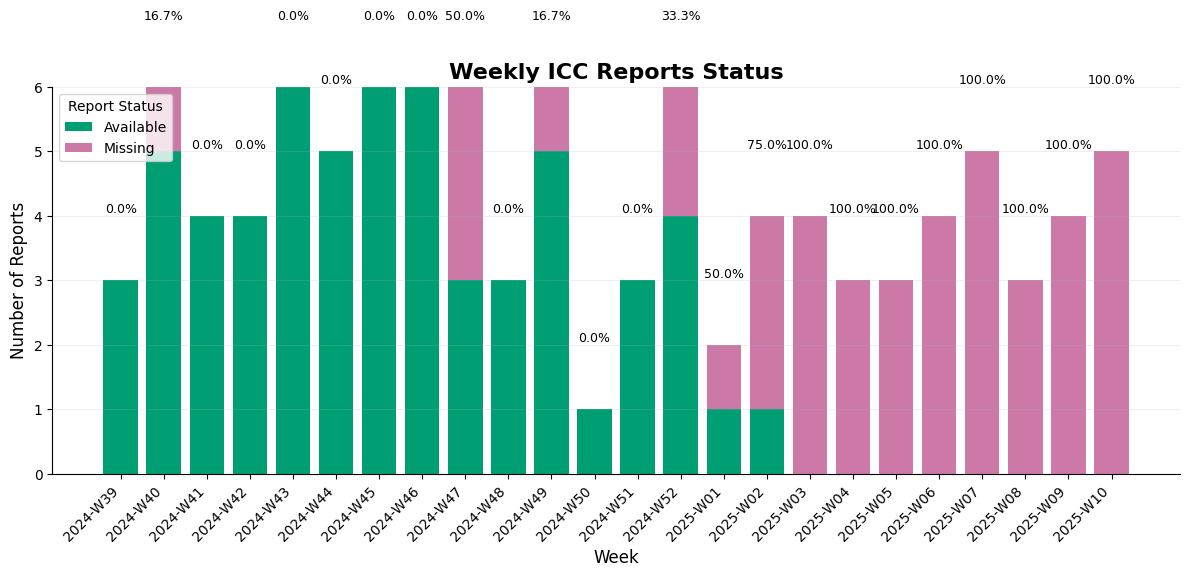

In [17]:
# Mark missing reports
df["has_report"] = ~df["report_date"].isna()

# Create week column based on changeout_date
df["week"] = df["changeout_date"].dt.isocalendar().week
df["year"] = df["changeout_date"].dt.isocalendar().year
df["yearweek"] = df["year"].astype(str) + "-W" + df["week"].astype(str).str.zfill(2)

# Weekly analysis of missing reports
weekly_summary = (
    df.groupby("yearweek")
    .agg(
        total=("equipment_name", "count"), missing=("has_report", lambda x: (~x).sum())
    )
    .reset_index()
)
weekly_summary["missing_percentage"] = (
    weekly_summary["missing"] / weekly_summary["total"] * 100
).round(1)
weekly_summary["available"] = weekly_summary["total"] - weekly_summary["missing"]

# Sort by yearweek to ensure chronological order
weekly_summary = weekly_summary.sort_values("yearweek")

# Use winter_bright colors
available_color = "#009E73"  # Green
missing_color = "#CC79A7"  # Purple

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create the stacked bars
weeks = range(len(weekly_summary))
week_labels = weekly_summary["yearweek"]
available = weekly_summary["available"]
missing = weekly_summary["missing"]

# Plot the stacked bars
ax.bar(weeks, available, label="Available", color=available_color)
ax.bar(weeks, missing, bottom=available, label="Missing", color=missing_color)

# Add percentage labels
for i, (total, missing_pct) in enumerate(
    zip(weekly_summary["total"], weekly_summary["missing_percentage"])
):
    ax.text(i, total + 1, f"{missing_pct}%", ha="center", va="bottom", fontsize=9)

# Set the x-ticks and labels
ax.set_xticks(weeks)
ax.set_xticklabels(week_labels, rotation=45, ha="right")

# Add titles and labels
ax.set_title("Weekly ICC Reports Status", fontsize=16, fontweight="bold")
ax.set_xlabel("Week", fontsize=12)
ax.set_ylabel("Number of Reports", fontsize=12)

# Add legend
ax.legend(title="Report Status", loc="upper left")

# Set background color to white and add grid lines only for y-axis
ax.set_facecolor("white")
ax.grid(axis="y", linestyle="-", alpha=0.2)

# Remove top and right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

plt.show()

In [14]:
plot_data

,yearweek,week_num,total,report_status,count
0,2024-W39,1,3,missing,0
1,2024-W40,2,6,missing,1
2,2024-W41,3,4,missing,0
3,2024-W42,4,4,missing,0
4,2024-W43,5,6,missing,0
5,2024-W44,6,5,missing,0
6,2024-W45,7,6,missing,0
7,2024-W46,8,6,missing,0
8,2024-W47,9,6,missing,3
9,2024-W48,10,3,missing,0


In [11]:
weekly_summary

,yearweek,total,missing,missing_percentage
0,2024-39,3,0,0.0
1,2024-40,6,1,16.7
2,2024-41,4,0,0.0
3,2024-42,4,0,0.0
4,2024-43,6,0,0.0
5,2024-44,5,0,0.0
6,2024-45,6,0,0.0
7,2024-46,6,0,0.0
8,2024-47,6,3,50.0
9,2024-48,3,0,0.0


asdasdasds